<a href="https://colab.research.google.com/github/lexiconlp/transformer-under-the-hood/blob/chore%2Fjupyters-notebooks/1_neural_network_explanation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Utils 🔨🪛🔩🔧

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch.autograd import Variable
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import Adam


In [ ]:
def highlight(row: pd.Series)-> list:
  if row.y == row.yhat:
    css = 'background-color: green'
  else: 
    css = ''
  return [css]*len(row)

def visualize_results(df_prob: pd.DataFrame,func_perceptron) -> pd.DataFrame:
  prediction = df_prob.apply(lambda row: func_perceptron(row.x1,row.x2),axis=1)

  df = pd.DataFrame(df_prob.assign(yhat=prediction))
  return df.style.apply(highlight, axis=1)

## train function

In [ ]:
def _train_model(
    model,x, y_true, epochs: int = 3
):
    weights1 = []
    bias1 = []
    weightsh = []
    biash = []
    
    optimizer = optim.Adam(model.parameters(), lr=1e-2)
    lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, patience=250, verbose=True
    )
    loss = nn.MSELoss()

    model.train()
    for i in range(epochs):
      optimizer.zero_grad()
      with torch.set_grad_enabled(True):
        y_pred = model(x)
        loss_ = loss(y_true,y_pred)
        loss_.backward()
        optimizer.step()
      
      # save intermediate linear weight
      weight1 = model.layers[0].weight.detach().numpy().copy()
      bia1 = model.layers[0].bias.detach().numpy().copy()
      weighth = model.layers[2].weight.detach().numpy().copy()
      biah = model.layers[2].bias.detach().numpy().copy()
      
      weights1.append(weight1)
      bias1.append(bia1)
      weightsh.append(weighth)
      biash.append(biah)


      if i%100 == 0:
        print(loss_.item())

    return weights1,bias1, weightsh, biash
    

A neural network is a set of **perceptrons**.

# 1. What is a **perceptron** ?

### 1.1 Perceptron definition

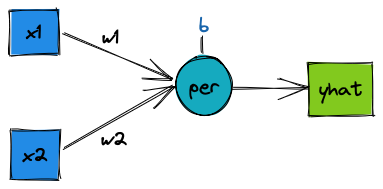

$y_{hat} = F_{activation}(x_{1}w_{1} + x_{2}w_{2} + b)$

### 1.2 And logic problem

In [ ]:
and_problem = pd.DataFrame({
    'x1':[0,0,1,1],
    'x2':[0,1,0,1],
    'y': [0,0,0,1]
})
and_problem

x1  x2  y
0   0   0  0
1   0   1  0
2   1   0  0
3   1   1  1

Let's try to solve it using a **perceptron**.

##1.3 Activation Function

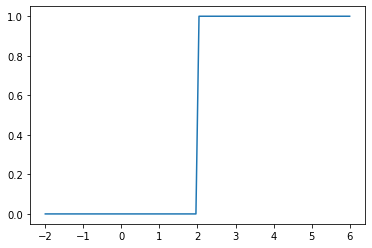

In [ ]:
# activation function
def heaviside(x: float) -> int:
  if x >= 2:
    return 1
  return 0

x = np.linspace(-2.0, 6.0,100)
plt.plot(x, [heaviside(i) for i in x])
plt.show()

## 1.4 Choose perceptron parameters manually

In [ ]:
b = 0

# which values of w1 and w2 solve "and_problem" ? 
w1 = 2
w2 = 2

def perceptron(x1: int, x2: int) -> int:
  return heaviside(x1*w1 + x2*w2 + b)

visualize_results(and_problem, perceptron)

----


How to calculate w1 and w2 automatically ? 

## 1.5 Gradient descent (Find parameters automatically)

desdecenso-gradiente.svg

ok ok, but... Where is the code ?

In [ ]:
w1 = 2
w2 = 2
alpha = .5

# e = 1/2(y-yhat)^2
# y = H(x1w1 + x2w2)
# de/dw1 = de/dy.dy/w1 = (y-yhat)*(x1)

# w1n = w1o - alpha*de/dw1
# grad = alpha*de/dw1 = alpha*(y-yhat)*(x1)
# w1n = w1o - grad

In [ ]:
and_problem

x1  x2  y
0   0   0  0
1   0   1  0
2   1   0  0
3   1   1  1

In [ ]:
# epochs and x1, x2 inputs

for _, row in and_problem.iterrows():
  y = perceptron(row.x1,row.x2)
  
  grad1 = (y-row.y)*(row.x1)
  grad2 = (y-row.y)*(row.x2)
  
  w1 = w1 - alpha*grad1
  w2 = w2 - alpha*grad2
  error = 1/2*(y-row.y)**2
  color_ini,color_end = "",""
  str_result = f"x1={row.x1} x2={row.x2} {color_ini}y={row.y} y_hat={y} {color_end} {error=} ---> {w1=} {w2=}"
  
  if error > 0:
    str_result = "\033[31m" + str_result + "\033[0m"
    
  print(str_result)
  print("--"*20)

x1=0 x2=0 y=0 y_hat=0  error=0.0 ---> w1=2.0 w2=2.0
----------------------------------------
x1=0 x2=1 y=0 y_hat=1  error=0.5 ---> w1=2.0 w2=1.5
----------------------------------------
x1=1 x2=0 y=0 y_hat=1  error=0.5 ---> w1=1.5 w2=1.5
----------------------------------------
x1=1 x2=1 y=1 y_hat=1  error=0.0 ---> w1=1.5 w2=1.5
----------------------------------------


In [ ]:
visualize_results(and_problem,perceptron)

We did it automatically 🎉🎉🎉 !!! 

But what does mean our solution ?? 🤔

## 1.6 What is a percetron ? 

In [ ]:
w1,w2, b

(1.5, 1.5, 0)

$2 = w_{1}x_{1} + w_{2}x_{2} + b$

In [ ]:
# 2 = row.x1*w1+row.x2*w2+b
# x2 = 2/w2 - row.x1*w1/w2 -b/w2

x2 = [2/w2 - row.x1*w1/w2 -b/w2 for _,row in and_problem.iterrows()]

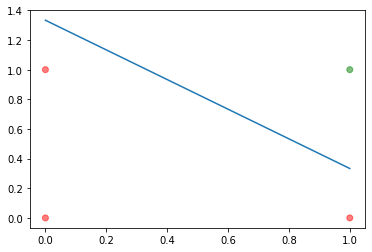

In [ ]:
colors = [{0: 'red',1:'green'}.get(y) for y in and_problem.y]
plt.scatter(and_problem.x1, and_problem.x2, c=colors, alpha=0.5)

plt.plot(and_problem.x1, x2)
plt.show()

Perceptron is an hiperplane !!! 🤯


Can a **perceptron** solve any kind of problem ?


## 1.7 XOR Problem

In [ ]:
xor_problem = pd.DataFrame({
    'x1':[0,0,1,1],
    'x2':[0,1,0,1],
    'y': [0,1,1,0]
})
xor_problem

x1  x2  y
0   0   0  0
1   0   1  1
2   1   0  1
3   1   1  0

In [ ]:
# which values of w1,w2, v solve "xor_problem" ? 
b = 0
w1 = 2
w2 = 2

visualize_results(xor_problem,perceptron)

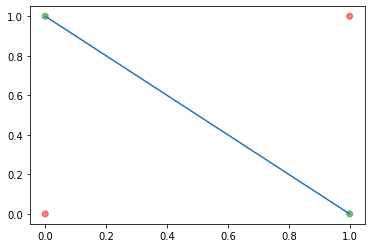

In [ ]:
colors = [{0: 'red',1:'green'}.get(y) for y in xor_problem.y]
plt.scatter(xor_problem.x1, xor_problem.x2, c=colors, alpha=0.5)

x2 = [2/w2 - row.x1*w1/w2 -b/w2 for _,row in xor_problem.iterrows()]
plt.plot(xor_problem.x1, x2)
plt.show()

-----

We cannot solve xor problem only with a **perceptron** 😔 

At least 🤔 .....  

Unless we deform space 🤯

But, ¿how we can deform space ? 

#2. Multilayer perceptron (MLP)

## 2.1 What is a MLP ?

Original space have x1,x2 axis, and our new deformed space have  h1,h2 axis.

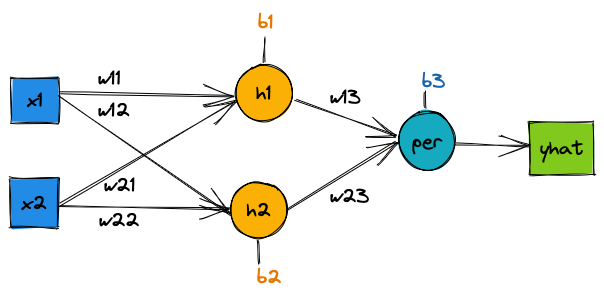

$h_{1} = F_{A}(w_{11}x_{1} + w_{21}x_{2} + b_{1})$




$h_{2} = F_{A}(w_{12}x_{1} + w_{22}x_{2} + b_{2})$


$y_{hat} = F_{A}(h_{1}w_{13} + h_{2}w_{23} + b_{3} )$



Matrix notation

$\begin{pmatrix} h_{1} \\ h_{2} \end{pmatrix} = F_{A}(\begin{pmatrix} x_{1} \ x_{2} \end{pmatrix}\begin{pmatrix} w_{11} & w_{12} \\ w_{21} & w_{22} \end{pmatrix}  + \begin{pmatrix} b_{1} \\ b_{2} \end{pmatrix})$

$y_{hat} = F_{A}(\begin{pmatrix} h_{1} \ h_{2} \end{pmatrix}\begin{pmatrix} w_{13} \\ w_{23} \end{pmatrix}  + b_{3} ) $

Now we have 9 parameters:

$w_{11},w_{12},b_{1},w_{21},w_{22},b_{2}, w_{31},w_{32},b_{3}$

## 2.2. Pytorch MLP definition

In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(2,2),
            nn.Sigmoid(),
            nn.Linear(2,1),
            nn.Sigmoid()
        )
                
    def forward(self,X):
        return self.layers(X)

## 2.2 Create model + data

In [ ]:
torch.manual_seed(0)
model = MLP()

In [ ]:
model.layers

Sequential(
  (0): Linear(in_features=2, out_features=2, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=2, out_features=1, bias=True)
  (3): Sigmoid()
)

In [ ]:
x = torch.Tensor([xor_problem.x1,xor_problem.x2]).T

# exercise for the reader:
# what happen if ".view(4,1)" it will remove ???
y = torch.Tensor(xor_problem.y).view(4,1)

In [ ]:
xor_problem

x1  x2  y
0   0   0  0
1   0   1  1
2   1   0  1
3   1   1  0

## 2.3 Train model 🚂

In [ ]:
EPOCHS = 100

i_dont_care = _train_model(model,x,y,EPOCHS)

0.25221654772758484


In [ ]:
# todo: move to utils
colors = [{0: 'red',1:'green'}.get(y) for y in xor_problem.y]

In [ ]:
model.eval()
linear_transform = model.layers[0](x)
h = model.layers[1](linear_transform)

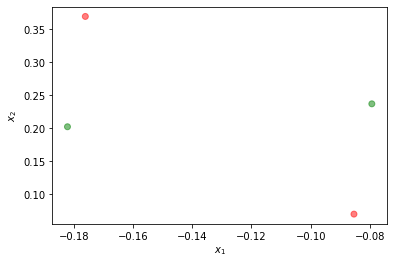

In [ ]:
# x1, x2
lin = linear_transform.detach().numpy()
plt.scatter(lin[:,0],lin[:,1], c=colors, alpha=0.5)
plt.xlabel('$x_{1}$')
plt.ylabel('$x_{2}$')
#plt.gca().set_xticklabels([])
#plt.gca().set_yticklabels([])
plt.show()

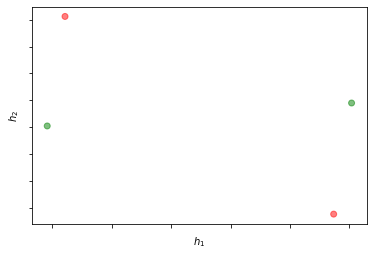

In [ ]:
# h1, h2

h = h.detach().numpy()
plt.scatter(h[:,0],h[:,1], c=colors, alpha=0.5)
plt.xlabel('$h_{1}$')
plt.ylabel('$h_{2}$')
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.show()

We cannot solve xor problem only with a **perceptron** 😔 ....

( if you [change activation](https://medium.com/@lucaspereira0612/solving-xor-with-a-single-perceptron-34539f395182) function you can solve xor problem only with one perceptron 💪)

# Visualize "learning" 😍😍😍

In [ ]:
torch.manual_seed(0)
model = MLP()
weights1,bias1, weightsh, biash = _train_model(model,x,y,800)

0.25221654772758484
0.24999311566352844
0.24732187390327454
0.12457680702209473
0.03986966237425804
0.018896646797657013
0.011302796192467213
0.007648775354027748


## utils

In [ ]:
def _np_sigmoid(x: np.ndarray) -> np.ndarray:
    return 1 / (1 + np.exp(-x))

def _transform_lines(points: np.ndarray, matrix: np.ndarray, bias:np.ndarray, grid_size: int, apply_sigmoid: bool) -> np.ndarray:
    X, Y = np.meshgrid(points, points)
    lines = np.zeros((2, grid_size, grid_size))
    for i in range(grid_size):
        lines[0, :, i] = X[:, i]
        lines[1, :, i] = Y[:, i]
        lines[0, i, :] = X[i, :]
        lines[1, i, :] = Y[i, :]
    transformed_lines = matrix @ lines.reshape(2, -1) + bias
    transformed_lines = transformed_lines.reshape(2, grid_size, grid_size)
    if apply_sigmoid:
        return _np_sigmoid(transformed_lines)
    return transformed_lines

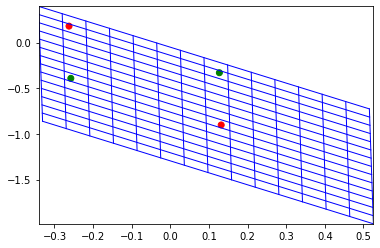

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def update(frame):
    # Compute the rotation matrix based on the frame number
    plt.clf()
    
    offsets = (-0.2, 2)
    grid_size = 15
    apply_sigmoid = False
    matrix = weights1[frame]
    bias = bias1[frame].reshape(2,1)

    points = np.linspace(*offsets, grid_size)
    sigmoid_lines = _transform_lines(points, matrix, bias, grid_size, apply_sigmoid)
    xmin, xmax = np.min(sigmoid_lines[0]), np.max(sigmoid_lines[0])
    ymin, ymax = np.min(sigmoid_lines[1]), np.max(sigmoid_lines[1])

    for i in range(grid_size):
        plt.plot(sigmoid_lines[0, :, i], sigmoid_lines[1, :, i], linewidth=1, color='blue')
        plt.plot(sigmoid_lines[0, i, :], sigmoid_lines[1, i, :], linewidth=1, color='blue')
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)

    points = np.array([[0, 0, 1, 1],
                       [0, 1, 0, 1]])
    colors = ['red', 'green', 'green', 'red']

    if apply_sigmoid:
        deform_points = _np_sigmoid(matrix @ points + bias)
    else:
        deform_points = matrix @ points + bias
    plt.scatter(deform_points[0, :], deform_points[1, :], c=colors)


# Set up the animation
fig = plt.figure()
ani = animation.FuncAnimation(fig, update, frames=range(300), interval=5)
ani.save('linear_learning.gif', writer='imagemagick')

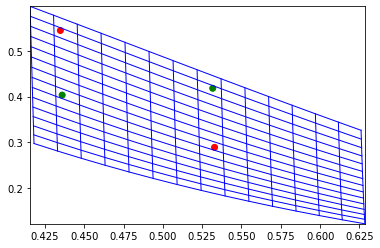

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def update(frame):
    # Compute the rotation matrix based on the frame number
    plt.clf()
    
    offsets = (-0.2, 2)
    grid_size = 15
    apply_sigmoid = True
    matrix = weights1[frame]
    bias = bias1[frame].reshape(2,1)

    points = np.linspace(*offsets, grid_size)
    sigmoid_lines = _transform_lines(points, matrix, bias, grid_size, apply_sigmoid)
    xmin, xmax = np.min(sigmoid_lines[0]), np.max(sigmoid_lines[0])
    ymin, ymax = np.min(sigmoid_lines[1]), np.max(sigmoid_lines[1])

    for i in range(grid_size):
        plt.plot(sigmoid_lines[0, :, i], sigmoid_lines[1, :, i], linewidth=1, color='blue')
        plt.plot(sigmoid_lines[0, i, :], sigmoid_lines[1, i, :], linewidth=1, color='blue')
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)

    points = np.array([[0, 0, 1, 1],
                       [0, 1, 0, 1]])
    colors = ['red', 'green', 'green', 'red']

    if apply_sigmoid:
        deform_points = _np_sigmoid(matrix @ points + bias)
    else:
        deform_points = matrix @ points + bias
    plt.scatter(deform_points[0, :], deform_points[1, :], c=colors)


# Set up the animation
fig = plt.figure()
ani = animation.FuncAnimation(fig, update, frames=range(300), interval=5)
ani.save('no_linear_learning.gif', writer='imagemagick')

## Display animation 😍

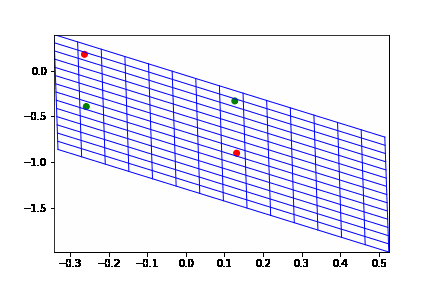

In [ ]:
from IPython.display import Image

Image(url='...')  # external
fname = 'linear_learning.gif'
Image(open(fname, 'rb').read())  # local

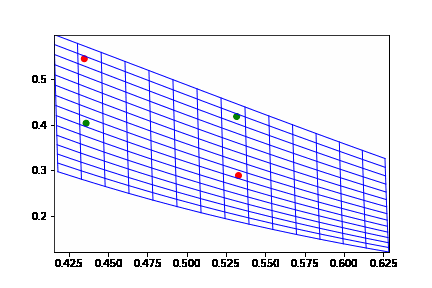

In [ ]:
from IPython.display import Image

Image(url='...')  # external
fname = 'no_linear_learning.gif'
Image(open(fname, 'rb').read())  # local

More complex dataset 😍



https://youtu.be/-at7SLoVK_I?t=408